# Test 1 
as discussed in the meeting @Cubotron on 02.06.2021

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import numpy as np

# Basic JAX
import jax
import jax.numpy as jnp
from jax.tree_util import tree_multimap
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Data.pixel_grid import PixelGrid
from jaxtronomy.Data.psf import PSF
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.ImSim.image_model import ImageModel
from jaxtronomy.Util import image_util

## Fixed parametric lens, fit a Sérsic source

### Data grids (image plane and source plane)
For simplicity, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (DeviceArray(-3.96, dtype=float64), DeviceArray(3.96, dtype=float64)) arcsec
y range    : (DeviceArray(-3.96, dtype=float64), DeviceArray(3.96, dtype=float64)) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.1, 'center_y': 0.05}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03}]

# lens_mass_model_list = ['SHEAR']
# lens_mass_model = LensModel(lens_mass_model_list)
# kwargs_lens_mass = [{'gamma1': -0.01, 'gamma2': 0.03}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.2}
psf = PSF(**kwargs_psf)

### Image model

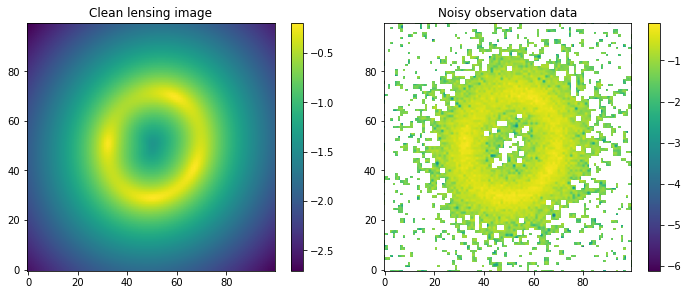

In [6]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
image_model = ImageModel(data_class=pixel_grid,
                         psf_class=psf,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

image = image_model.image(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light,
                          kwargs_ps={})

# Noise
exp_time = 100
sigma_bkd = 0.05
poisson = image_util.add_poisson(image, exp_time)
gaussian = image_util.add_background(image, sigma_bkd)
image_noisy = image + gaussian + poisson

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(jnp.log10(image), origin='lower')
ax1.set_title("Clean lensing image")
img2 = ax2.imshow(jnp.log10(image_noisy), origin='lower')
ax2.set_title("Noisy observation data")
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()
    
data = image_noisy

In [8]:
# (Don't trus this the first time you run it.)
%timeit image_model.image(kwargs_lens_mass, kwargs_source_light, kwargs_lens_light, kwargs_ps={})

2.33 ms ± 90.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Loss function

In [7]:
# def loss(params):
#     # Compute reconstruction with these lens parameters
#     rec = image_model.image(kwargs_lens=params['kwargs_lens_mass'],
#                             kwargs_source=params['kwargs_source_light'],
#                             kwargs_lens_light=params['kwargs_lens_light'],
#                             kwargs_ps={})

#     # Quadratic data fidelity term
#     sigma = jnp.sqrt(jnp.sqrt(gaussian.var() + poisson.var()))
#     loss = 0.5 * jnp.mean(((data - rec) / sigma)**2)
    
#     # Regularisation
#     # loss += ...
    
#     return loss
# 
# @jax.jit
# def grad_loss(params):
#     return jax.grad(loss)(params)


def create_loss_func(model, data, noise_var=1):
    def loss_func(params):
        rec = model.image(kwargs_lens=params['kwargs_lens_mass'],
                          kwargs_source=params['kwargs_source_light'],
                          kwargs_lens_light=params['kwargs_lens_light'],
                          kwargs_ps={})
        
        # Quadratic data fidelity term
        
        # sigma = jnp.sqrt(gaussian.var() + poisson.var())
        loss = 0.5 * jnp.mean((data - rec)**2 / noise_var)

        # Regularisation
        # loss += ...
        return loss
    return jax.jit(loss_func)

# class Metrics(object):
#     def __init__(self):
#         self.loss = []
    
#     def compute_metrics(self, z):
#         self.loss.append(lens_loss(z))

# Create loss and grad(loss) functions of parameter dictionaries
noise_var = gaussian.var() + poisson.var()
loss = create_loss_func(image_model, data, noise_var)
grad_loss = jax.jit(jax.grad(loss))

In [8]:
p = {'kwargs_lens_mass': [{'theta_E': 1.6, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.0, 'center_y': 0.0},
                          {'gamma1': -0.01, 'gamma2': 0.03}],
     'kwargs_source_light': [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.1, 'center_y': 0.05}],
     'kwargs_lens_light': [{}]}

In [9]:
loss(p)

DeviceArray(0.63269637, dtype=float64)

In [10]:
grad_loss(p)

{'kwargs_lens_light': [{}],
 'kwargs_lens_mass': [{'center_x': DeviceArray(0.48380721, dtype=float64),
   'center_y': DeviceArray(0.15132197, dtype=float64),
   'e1': DeviceArray(-1.46113885, dtype=float64),
   'e2': DeviceArray(0.60061639, dtype=float64),
   'theta_E': DeviceArray(0.4515221, dtype=float64)},
  {'gamma1': DeviceArray(3.03559896, dtype=float64),
   'gamma2': DeviceArray(-1.07127274, dtype=float64)}],
 'kwargs_source_light': [{'R_sersic': DeviceArray(0.31943773, dtype=float64),
   'amp': DeviceArray(0.07788379, dtype=float64),
   'center_x': DeviceArray(-0.53757149, dtype=float64),
   'center_y': DeviceArray(-0.17319655, dtype=float64),
   'n_sersic': DeviceArray(0.6823689, dtype=float64)}]}

In [64]:
from scipy.optimize import minimize

In [118]:
@jax.jit
def func(v):
    p = {'kwargs_lens_mass': [{'theta_E': v[0], 'e1': v[1], 'e2': v[2], 'center_x': 0.0, 'center_y': 0.0},
                              {'gamma1': v[3], 'gamma2': v[4]}],
         'kwargs_source_light': [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.1, 'center_y': 0.05}],
         'kwargs_lens_light': [{}]}
    return loss(p)

@jax.jit
def grad_func(v):
    p = {'kwargs_lens_mass': [{'theta_E': v[0], 'e1': v[1], 'e2': v[2], 'center_x': 0.0, 'center_y': 0.0},
                              {'gamma1': v[3], 'gamma2': v[4]}],
         'kwargs_source_light': [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.1, 'center_y': 0.05}],
         'kwargs_lens_light': [{}]}
    grad = grad_loss(p)['kwargs_lens_mass'][0]
    return [grad['theta_E'], grad['e1'], grad['e2'], grad['center_x'], grad['center_y']]

In [119]:
func([1.5, -0.03, 0.02, 0.0, 0.0])

DeviceArray(0.82216848, dtype=float64)

In [120]:
grad_func([1.5, -0.03, 0.02, 0.0, 0.0])

[DeviceArray(-1.42468301, dtype=float64),
 DeviceArray(-0.92570174, dtype=float64),
 DeviceArray(0.56403494, dtype=float64),
 DeviceArray(0.88314399, dtype=float64),
 DeviceArray(0.12647193, dtype=float64)]

In [121]:
opt = minimize(func, [1.0, 0., 0.0001, 0.0, 0.0], method='BFGS', jac=grad_func)

In [122]:
opt

      fun: 0.7545587512695812
 hess_inv: array([[ 0.07599347,  0.02110064, -0.02330613, -0.01473178,  0.02115255],
       [ 0.02110064,  0.15312837, -0.02062424,  0.0072874 , -0.12432763],
       [-0.02330613, -0.02062424,  0.11541435, -0.00841985,  0.06033839],
       [-0.01473178,  0.0072874 , -0.00841985,  0.15763646, -0.25982504],
       [ 0.02115255, -0.12432763,  0.06033839, -0.25982504,  0.90277739]])
      jac: array([ 1.06095445,  0.4008499 , -0.78467953,  0.04244156, -0.08875819])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 67
      nit: 5
     njev: 55
   status: 2
  success: False
        x: array([ 1.71266406, -0.18201535, -0.37728248, -0.18597138, -0.07454664])